In [20]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'; 
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn import metrics as skmetrics
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils.vis_utils import plot_model
from sklearn.ensemble import RandomForestClassifier
import h5py
from tables import *
from keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score,precision_recall_curve,auc,roc_curve, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.utils import shuffle
import pickle

# Load Dataset

In [21]:
train_filename='dataset_training_new.csv'
df=pd.read_csv(train_filename, nrows=15899, header=0,comment='#', na_values=[""])


In [22]:
# Data preparation
X_train = df.drop(['target'], axis = 1).values
y_train = df['target'].values

print("Input shape (X_train): {} --- Output shape (y_train): {}".format(X_train.shape, y_train.shape))

Input shape (X_train): (14925, 4) --- Output shape (y_train): (14925,)


In [23]:
#shuffle data
X_train, y_train = shuffle(X_train, y_train)
print(X_train)
print(y_train)

[[9967 9102 8906 6661]
 [5950 8514 8362 5995]
 [8249 7976 7854 5410]
 ...
 [5780 5559 5617 3943]
 [7114 7823 7712 5639]
 [7079 7894 7779 5715]]
[2 1 1 ... 0 1 1]


# GridSearch

In [24]:
hyperparameter_space = {'max_depth':[5,10,15],
                        'min_samples_leaf':[5,10,15],
                        'min_samples_split':[5,10,15],
                        'n_estimators':[50,100,150],}

In [25]:
rs = GridSearchCV( estimator=RandomForestClassifier(),param_grid=hyperparameter_space)

In [26]:
rs.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [50, 100, 150]})

In [27]:
rs.best_params_

{'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 50}

*Model definition and compile*

In [28]:
rf_model = RandomForestClassifier(n_estimators=50, max_features="auto", random_state=44, max_depth=5, min_samples_leaf=5, min_samples_split=5)


# Build Starting Network

In [29]:
rf_model.fit(X_train, y_train)

c:\Users\Windows\Desktop\Magistrale\venv\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=5, max_features='auto', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=50, random_state=44)

In [30]:
train_filename='dataset_test_new.csv'
df_test=pd.read_csv(train_filename, nrows=8960, header=0,comment='#', na_values=[""])

In [31]:
# Data preparation
X_test = df_test.drop(['target'], axis = 1).values
y_test = df_test['target'].values

print("Input shape (X): {} --- Output shape (y): {}".format(X_test.shape, y_test.shape))

Input shape (X): (8960, 4) --- Output shape (y): (8960,)


In [32]:
#shuffle
X_test, y_test = shuffle(X_test, y_test)

In [33]:
y_pred = rf_model.predict(X_test)
y_pred

array([1, 2, 1, ..., 2, 1, 0], dtype=int64)

In [34]:
CM=confusion_matrix(y_test,y_pred)

In [35]:
cm_df = pd.DataFrame(confusion_matrix(y_test,y_pred),
                     index = ['0','1','2'], 
                     columns =['0','1','2'])

Text(33.22222222222222, 0.5, 'Actual\xa0Values')

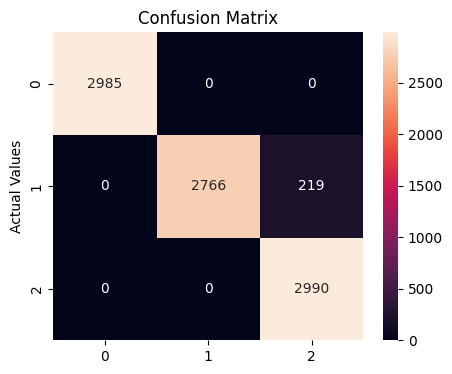

In [36]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4),)
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')

In [37]:
def recall(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1, 2)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1, 2)))
    recall_v = true_positives / (possible_positives + K.epsilon())
    return recall_v

def precision(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1, 2)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1, 2)))
    precision_v = true_positives / (predicted_positives + K.epsilon())
    return precision_v

def f1score(y_test, y_pred):
    precision_v = precision(y_test, y_pred)
    recall_v = recall(y_test, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

In [38]:
#Accuracy
acc = accuracy_score(y_test,y_pred)
acc

0.9755580357142857

In [39]:
#f1 scores of different models on VALIDATION SET 
f1_model1 = f1_score(y_test,y_pred, average='weighted')
f1_model1

0.9755244028980483

In [40]:
#RECALL of different models on VALIDATION SET 
recall1 = recall_score(y_test,y_pred, average='weighted')
recall1

0.9755580357142857

In [41]:
#save
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model,f)

In [43]:
#load
with open('rf_model.pkl', 'rb') as f:
    rf_test=pickle.load(f)


In [44]:
rf_test.fit(X_test, y_test)

c:\Users\Windows\Desktop\Magistrale\venv\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=5, max_features='auto', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=50, random_state=44)

In [45]:
rf_test.predict(X_test)

array([1, 2, 1, ..., 2, 1, 0], dtype=int64)